Because you can’t treat every customer the same way with the same content, same channel, same importance. They will find another option which understands them better.   

You can do many different segmentations according to what you are trying to achieve. If you want to increase retention rate, you can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now we are going to implement one of them to our business: RFM.   

RFM stands for **Recency - Frequency - Monetary Value**. Theoretically we will have segments like below:  

•	**Low Value:** Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.   
•	**Mid Value:** In the middle of everything. fairly frequent and generates moderate revenue.   
•	**High Value:** The group we don’t want to lose. High Revenue, Frequency and low Inactivity


In [1]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
tx_data = pd.read_csv('./Downloads/data/OnlineRetail.csv',encoding= 'unicode_escape')

tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

### Create a generic user dataframe to keep CustomerID and new segmentation scores

In [3]:
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0



# Recency  

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means clustering to assign customers a recency score.


In [4]:
#get the max purchase date for each customer and create a dataframe with it

tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [5]:
# we take our observation point as the max invoice date in our dataset (the most recent day)
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [6]:
# Merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [7]:
tx_user.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

We are going to apply K-means clustering to assign a **recency score**. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method.

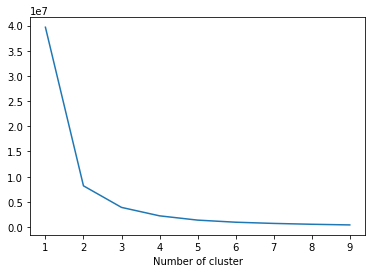

In [8]:
from sklearn.cluster import KMeans


sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 for this example:

In [9]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
3,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0


 K-means assigns clusters as numbers but not in an ordered way. We can’t say cluster 0 is the worst and cluster 4 is the best. order_cluster() method does this for us and our new dataframe looks much neater:

In [10]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [11]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

# Frequency  

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database:


In [12]:
#get order counts for each user and create a dataframe with it

tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [13]:
# merge this data to our main dataframe

tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


In [14]:
tx_user.Frequency.describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: Frequency, dtype: float64

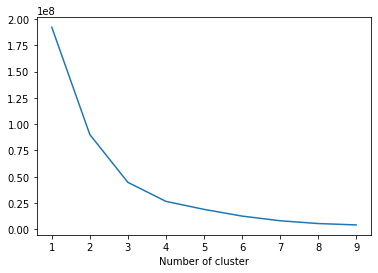

In [15]:
sse={}
tx_frequency = tx_user[['Frequency']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

**Apply the same logic for having frequency clusters and assign this to each customer**

In [16]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])


#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


# Monetary Value

In [17]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [18]:
# merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.Revenue.describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: Revenue, dtype: float64

We observe that some customers have negative revenue, that may be the loss due to return products

In [19]:
import warnings
warnings.filterwarnings("ignore")

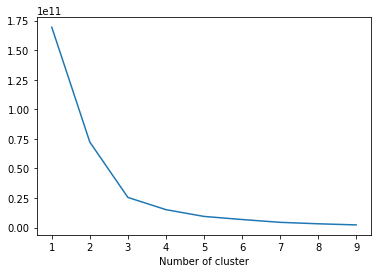

In [20]:
sse={}
tx_revenue = tx_user[['Revenue']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [22]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


# Overall Segmentation    

Our approach here is to build seperate segment for each of RFM. Then the RFM score (Overall score) is a combination of these values for each customer.

In [23]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1


In [24]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.
To keep things simple, better we name these scores:   
•	0 to 2: Low Value    
•	3 to 4: Mid Value   
•	5+: High Value    

Let see the count of each group.



In [25]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0     474
1     562
2     920
3    1511
4     298
5     148
6      27
7       7
8       3
Name: Recency, dtype: int64

In [26]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [27]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


We can start taking actions with this segmentation. The main strategies are quite clear:
•	High Value: Improve Retention
•	Mid Value: Improve Retention + Increase Frequency
•	Low Value: Increase Frequency
